In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import pydicom as dicom
from pydicom.data import get_testdata_file

os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
from segmentation_models import Unet,get_preprocessing

2024-03-08 19:32:15.105706: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-08 19:32:15.219689: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-08 19:32:15.740938: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-08 19:32:17.986810: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Segmentation Models: using `tf.keras` framework.


In [2]:
BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)

In [3]:
model = tf.keras.models.load_model("best_model.keras",compile= False)

2024-03-08 19:32:25.410191: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-08 19:32:25.427931: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [8]:
img_path = 'data/train/100051/image/1-001.png'
msk_path = 'data/train/100051/mask/1-001.png'
img_width = 256
img_height = 256
def preprocess(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (img_width, img_height))
    img = np.array(img)
    # img=np.stack((img,)*3,axis=-1)
    # img = img.reshape(1,img.shape[0],img.shape[1],img.shape[2])
    if "mask" in img_path:
        img = img/255
    else:
        img=img/img.max()
    img=img.astype(np.float32)
    return img


In [14]:
img = cv2.imread(img_path)
img = cv2.resize(img, (img_width, img_height))
img = np.array(img)
img.shape

(256, 256, 3)

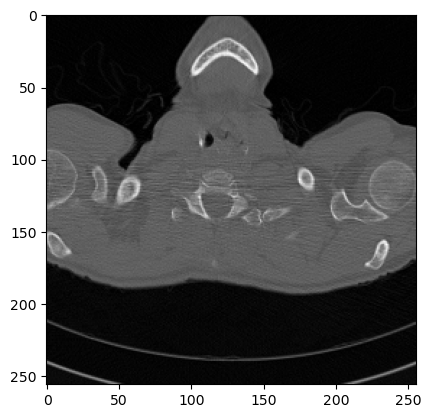

In [15]:
img = preprocess(img_path)
plt.imshow(img)

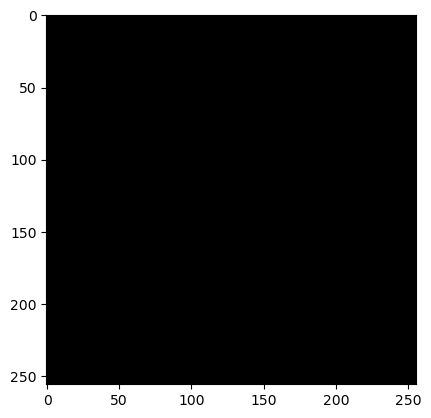

In [16]:
msk = preprocess(msk_path)
plt.imshow(msk)

In [17]:
img = img.reshape(1,img.shape[0],img.shape[1],img.shape[2])
img= preprocess_input(img)
q = model.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


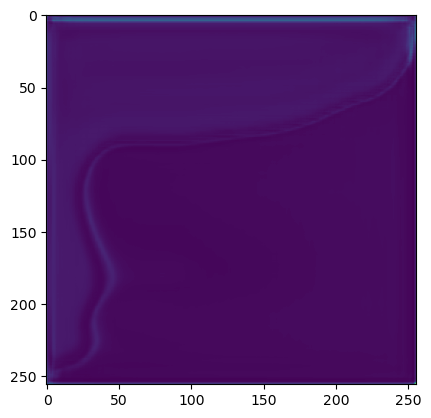

In [18]:
plt.imshow(q[0])

In [19]:
import glob as gb
train_path = "data/train/"
# setting image height and width
img_width = 256
img_height = 256
# initialize list x-train and y-train
X_train=[]
Y_train=[]

for folder in os.listdir(train_path): 
    files=gb.glob(train_path+folder+'/image/*.png')
    for file in files :
        img =cv2.imread(file,0)
        img = cv2.resize(img, (img_width, img_height)) 
        X_train.append(list(img)) 
    files=gb.glob(train_path+folder+'/mask/*.png')
    for file in files :
        img =cv2.imread(file,0)
        img = cv2.resize(img, (img_height, img_width)) 
        Y_train.append(list(img)) 

In [20]:
# def preprocess(data):
X_train=np.array(X_train)
X_train=np.stack((X_train,)*3,axis=-1)
X_train = X_train/X_train.max()
X_train=X_train.astype(np.float32)

Y_train=np.array(Y_train,np.bool_)
Y_train = Y_train/255
Y_train=np.expand_dims(Y_train,axis=-1)
Y_train=Y_train.astype(np.float32)
    

In [21]:
scans = list(np.random.randint(0,len(Y_train),16))

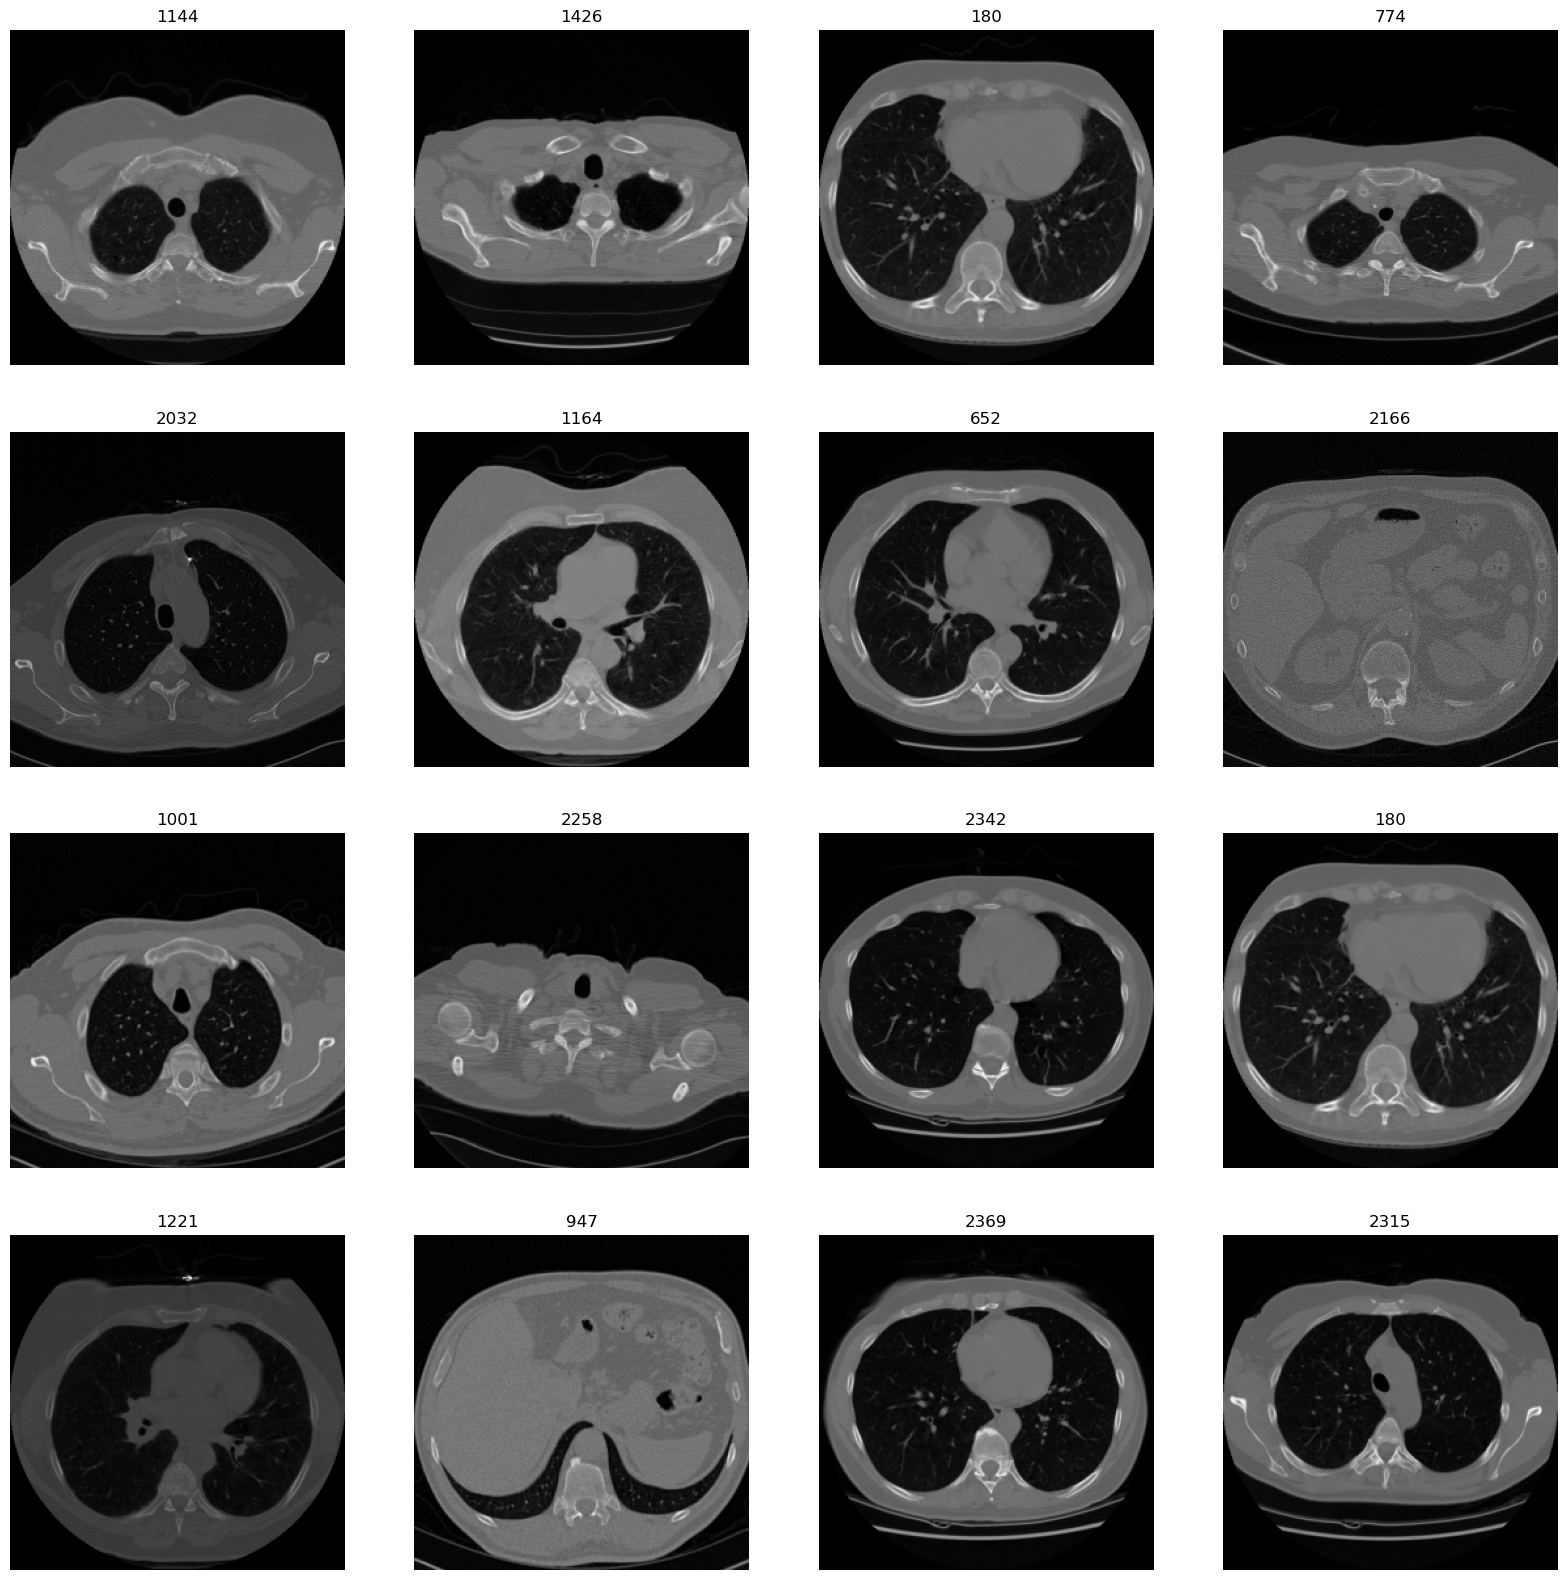

In [22]:
plt.figure(figsize=(20,20));
for n ,i in enumerate(scans):
    plt.subplot(4,4,n+1)
    plt.imshow(X_train[i],cmap='gray')
    plt.axis('off')
    plt.title(i)

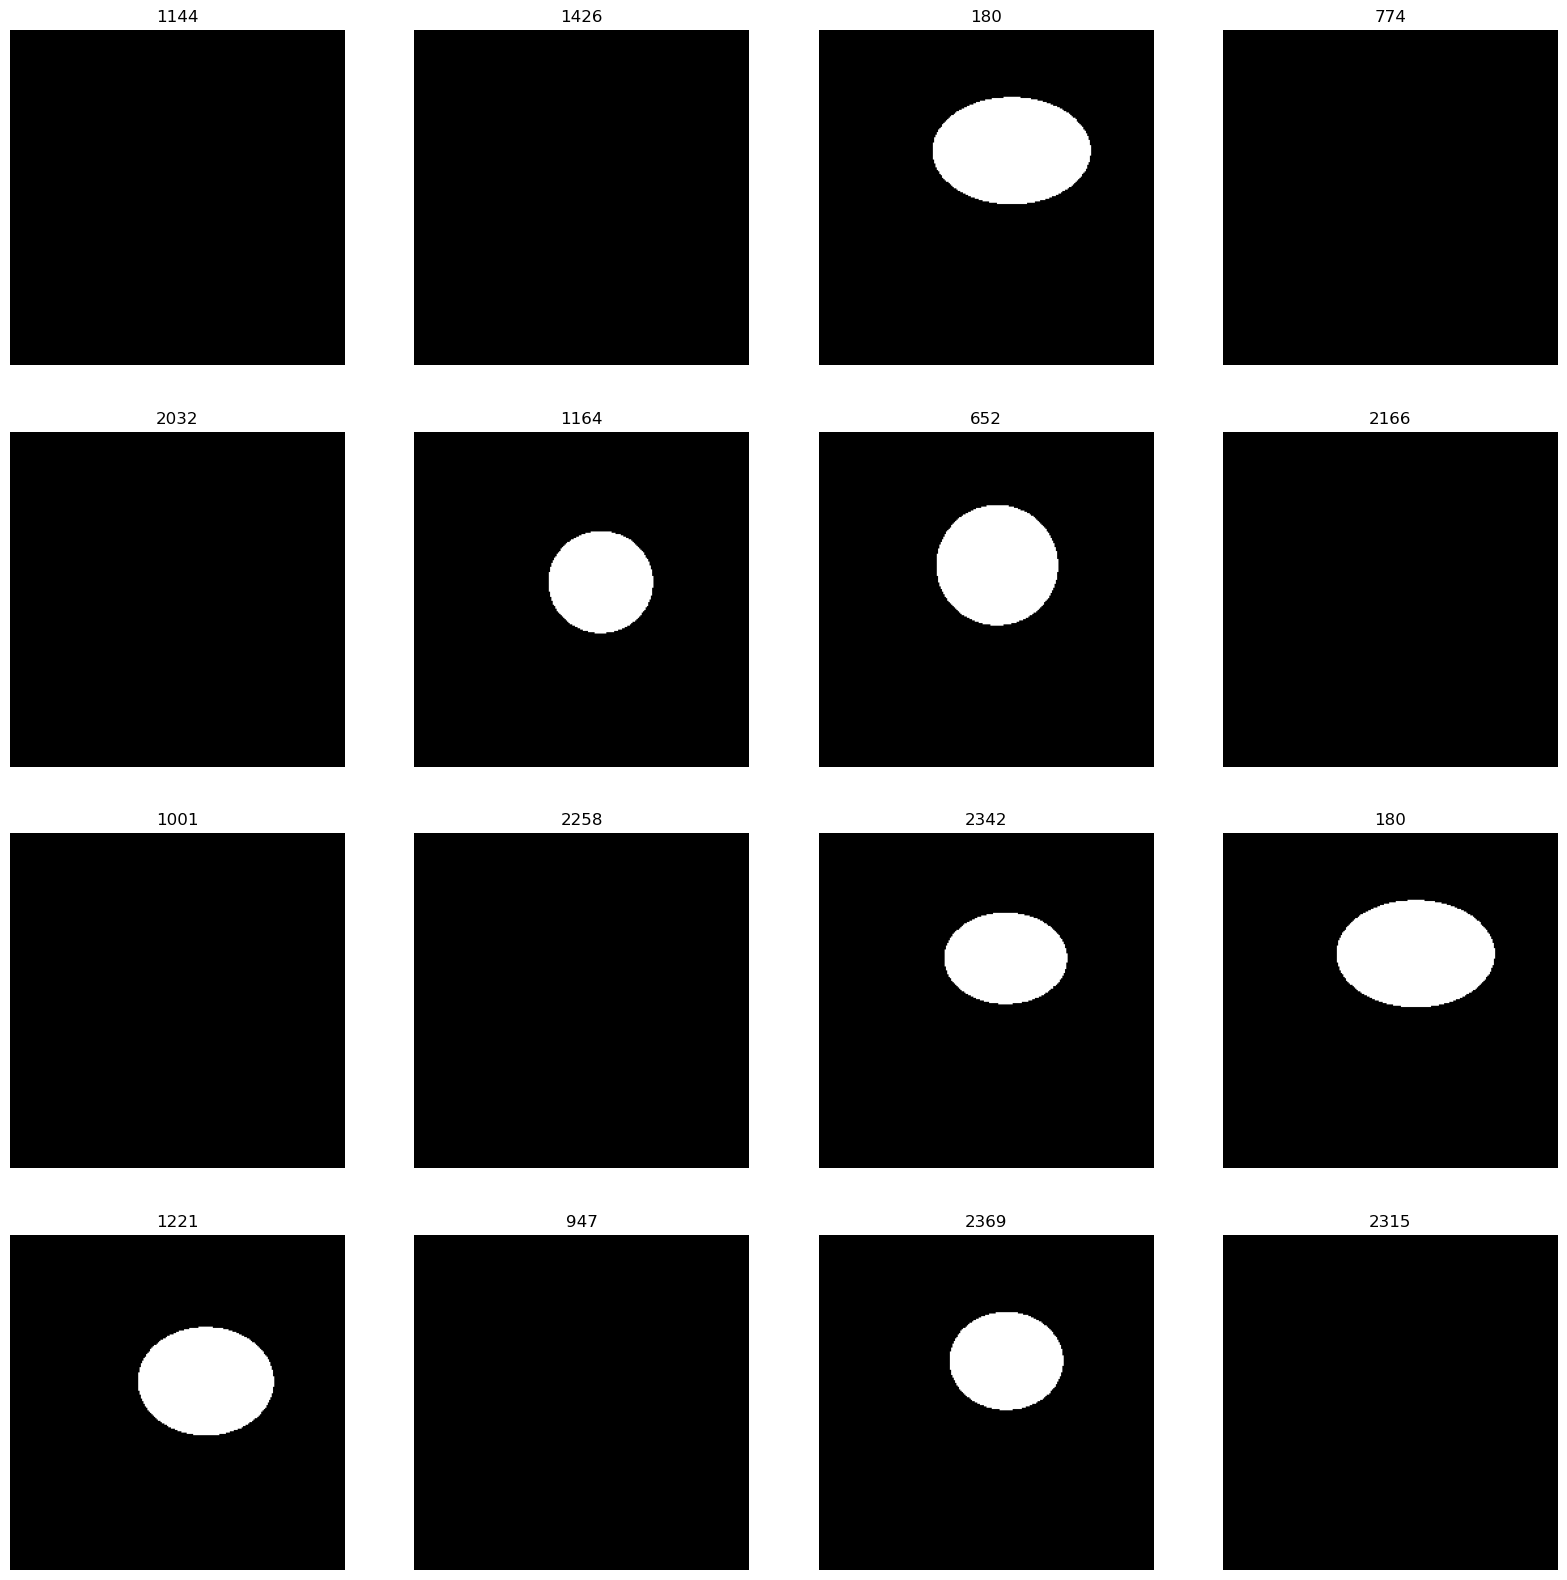

In [23]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(scans) :
    plt.subplot(4,4,n+1)
    plt.imshow(Y_train[i],cmap='gray')
    plt.axis('off')
    plt.title(i)

In [26]:
X_train= preprocess_input(X_train)

In [27]:
q = model.predict(X_train)

2024-03-08 19:37:43.212050: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1991245824 exceeds 10% of free system memory.
2024-03-08 19:37:49.399901: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.
2024-03-08 19:37:49.513905: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 138444800 exceeds 10% of free system memory.
2024-03-08 19:37:51.595958: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 100663296 exceeds 10% of free system memory.
2024-03-08 19:37:51.840873: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.


80/80 ━━━━━━━━━━━━━━━━━━━━ 253s 3s/step


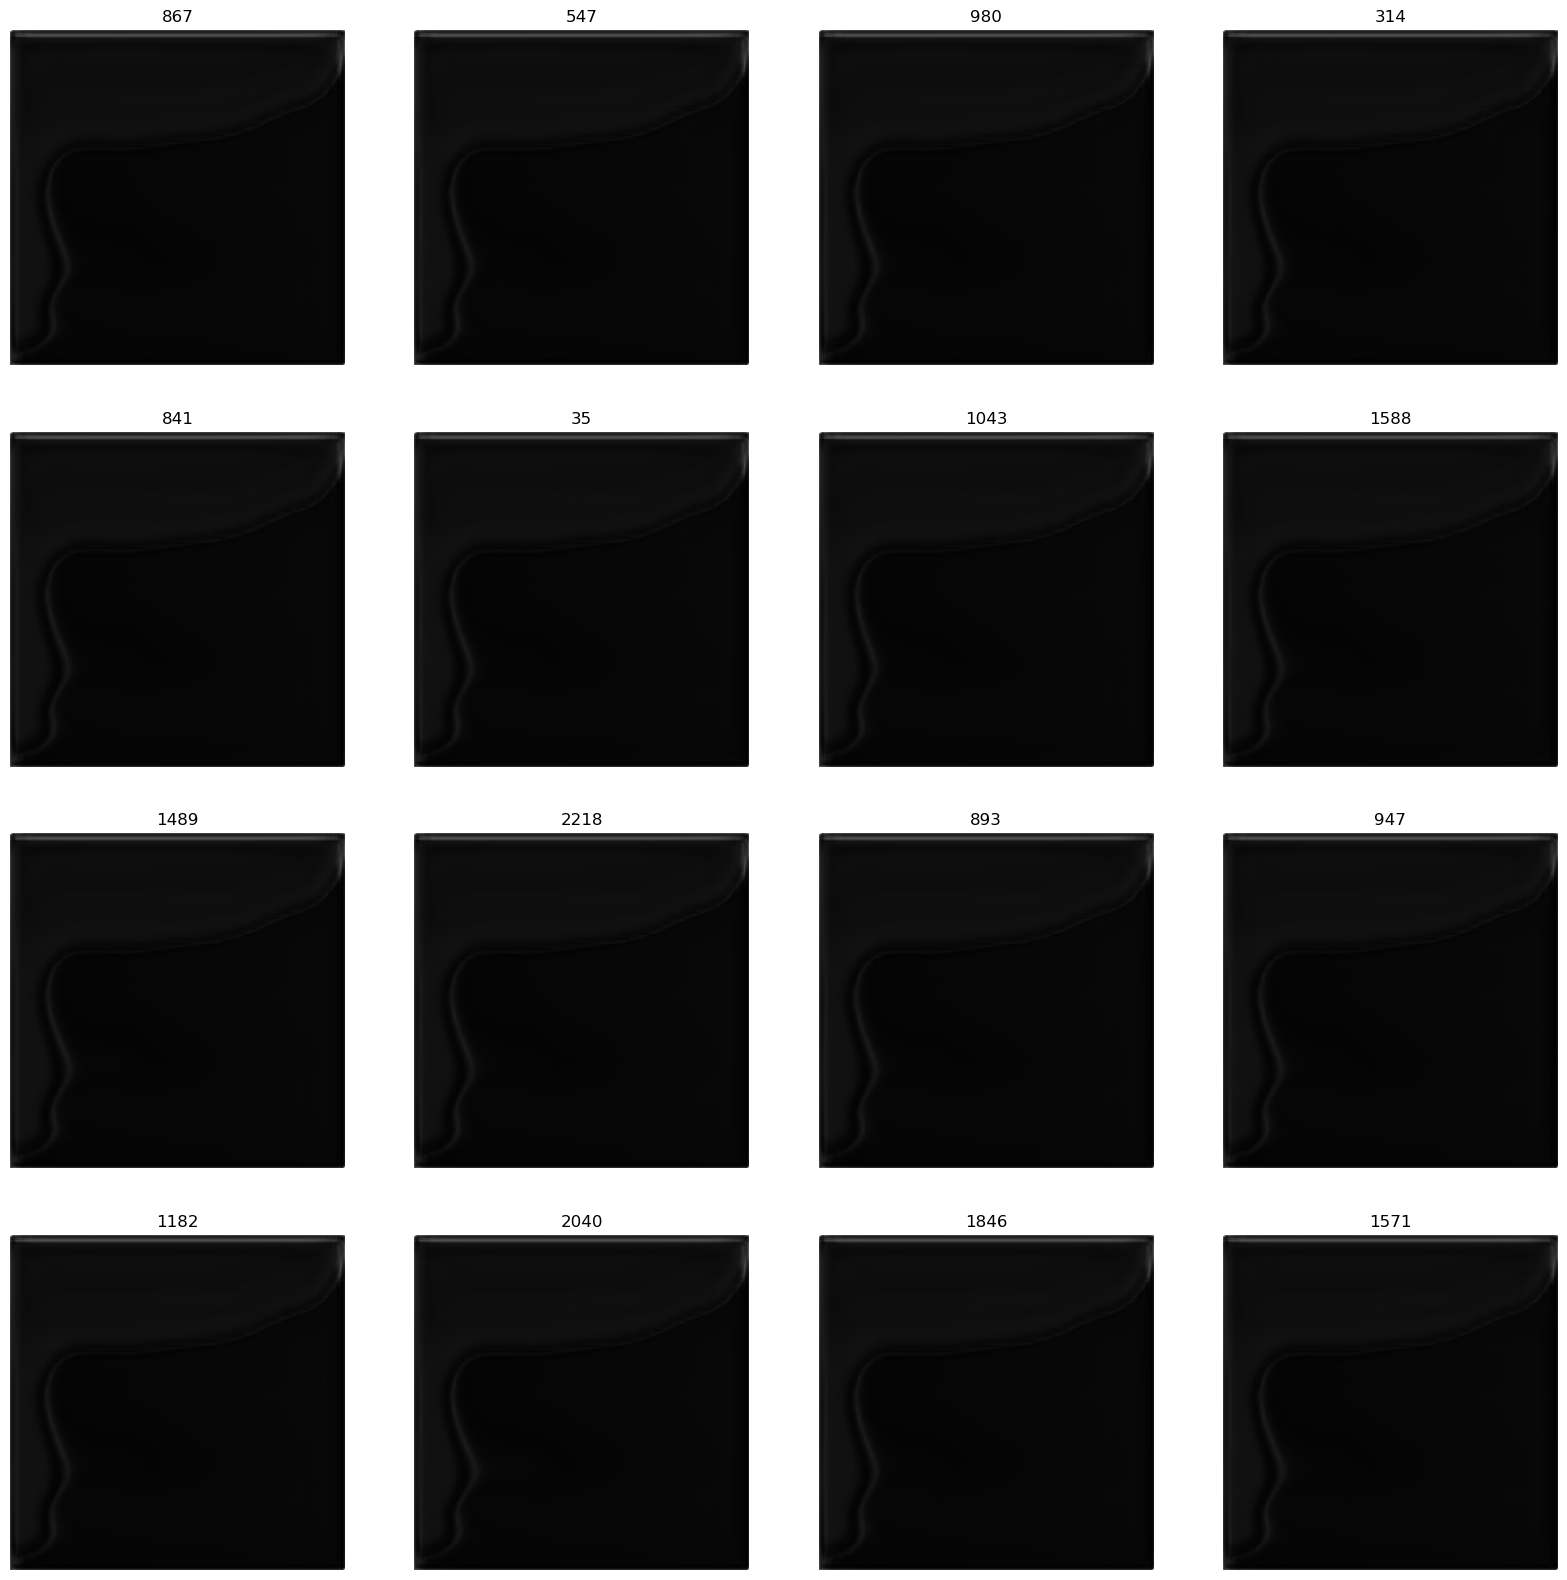

In [34]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(list(np.random.randint(0,len(Y_train),16))) :
    plt.subplot(4,4,n+1)
    plt.imshow(q[i],cmap='gray')
    plt.axis('off')
    plt.title(i)

In [4]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.losses import Loss

class DiceLoss(Loss):
    def __init__(self, mode, classes=None, log_loss=False, from_logits=True, smooth=0.0, ignore_index=None, eps=1e-7):
        super(DiceLoss, self).__init__()
        self.mode = mode
        self.classes = classes
        self.from_logits = from_logits
        self.smooth = smooth
        self.eps = eps
        self.log_loss = log_loss
        self.ignore_index = ignore_index

    def call(self, y_true, y_pred):
        # Implement the Dice Loss calculation here.
        return self.compute_loss(y_true, y_pred)

    def get_config(self):
        return {
            'mode': self.mode,
            'classes': self.classes,
            'log_loss': self.log_loss,
            'from_logits': self.from_logits,
            'smooth': self.smooth,
            'ignore_index': self.ignore_index,
            'eps': self.eps
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)

    def call(self, y_true, y_pred):
        if self.from_logits:
            y_pred = tf.nn.sigmoid(y_pred) if self.mode != MULTICLASS_MODE else tf.nn.softmax(y_pred)
    
        if self.mode == BINARY_MODE:
            y_true = tf.expand_dims

In [10]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [12]:
import tensorflow as tf

class DiceLoss(tf.keras.losses.Loss):
    def __init__(self, mode, classes=None, log_loss=False, from_logits=True, smooth=0.0, ignore_index=None, eps=1e-7):
        super().__init__()
        self.mode = mode
        self.classes = classes
        self.from_logits = from_logits
        self.smooth = smooth
        self.eps = eps
        self.log_loss = log_loss
        self.ignore_index = ignore_index

    def call(self, y_true, y_pred):
        assert y_true.size(0) == y_pred.size(0)

        if self.from_logits:
            # Apply activations to get [0..1] class probabilities
            # Using Log-Exp as this gives more numerically stable result and does not cause vanishing gradient on
            # extreme values 0 and 1
            if self.mode == MULTICLASS_MODE:
                y_pred = y_pred.log_softmax(dim=1).exp()
            else:
                y_pred = F.logsigmoid(y_pred).exp()

        bs = y_true.size(0)
        num_classes = y_pred.size(1)
        dims = (0, 2)

        if self.mode == BINARY_MODE:
            y_true = y_true.view(bs, 1, -1)
            y_pred = y_pred.view(bs, 1, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        if self.mode == MULTICLASS_MODE:
            y_true = y_true.view(bs, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask.unsqueeze(1)

                y_true = F.one_hot((y_true * mask).to(torch.long), num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1) * mask.unsqueeze(1)  # N, C, H*W
            else:
                y_true = F.one_hot(y_true, num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1)  # N, C, H*W

        if self.mode == MULTILABEL_MODE:
            y_true = y_true.view(bs, num_classes, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        scores = self.compute_score(y_pred, y_true.type_as(y_pred), smooth=self.smooth, eps=self.eps, dims=dims)

        if self.log_loss:
            loss = -torch.log(scores.clamp_min(self.eps))
        else:
            loss = 1.0 - scores

        # Dice loss is undefined for non-empty classes
        # So we zero contribution of channel that does not have true pixels
        # NOTE: A better workaround would be to use loss term `mean(y_pred)`
        # for this case, however it will be a modified jaccard loss

        mask = y_true.sum(dims) > 0
        loss *= mask.to(loss.dtype)

        if self.classes is not None:
            loss = loss[self.classes]

        return self.aggregate_loss(loss)

    def aggregate_loss(self, loss):
        return loss.mean()

    def compute_score(self, output, target, smooth=0.0, eps=1e-7, dims=None) -> torch.Tensor:
        return soft_dice_score(output, target, smooth, eps, dims)

    def get_config(self):
        return {
            'mode': self.mode,
            'classes': self.classes,
            'log_loss': self.log_loss,
            'from_logits': self.from_logits,
            'smooth': self.smooth,
            'ignore_index': self.ignore_index,
            'eps': self.eps
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)

IndentationError: expected an indented block after function definition on line 14 (697587114.py, line 17)

In [11]:
from tensorflow.keras.models import load_model
model = load_model('./heart_segmentation-model.keras',custom_objects={'DiceLoss': sm.losses.DiceLoss()})
# model.compile(optimizer='adam',loss=sm.losses.DiceLoss(),metrics = [tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), tf.keras.metrics.AUC(),sm.metrics.iou_score,sm.metrics.FScore(threshold=0.5)])

TypeError: Unable to reconstruct an instance of 'DiceLoss' because the class is missing a `from_config()` method. Full object config: {'module': 'segmentation_models.losses', 'class_name': 'DiceLoss', 'config': 'dice_loss', 'registered_name': 'DiceLoss'}

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd 
import tensorflow as tf
import pydicom as dicom
from tensorflow import keras
from keras.models import load_model 
from keras import backend as K
import matplotlib.pyplot as plt
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
from segmentation_models import Unet,get_preprocessing
from keras.utils import plot_model
from keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint


2024-04-09 19:41:38.541621: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-09 19:41:39.332650: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Segmentation Models: using `tf.keras` framework.
